In [12]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


num_samples = 1000
start_time = datetime(2025, 4, 15, 12, 0, 0)
timestamps = [start_time + timedelta(minutes=i) for i in range(num_samples)]
sensor_ids = np.random.choice(['S001', 'S002', 'S003'], size=num_samples)


temperature = np.random.normal(loc=22, scale=5, size=num_samples)
humidity = np.random.normal(loc=50, scale=10, size=num_samples)
motion = np.random.choice([0, 1], size=num_samples, p=[0.9, 0.1])


anomaly_flag = ((temperature > 35) | (temperature < 5) |
                (humidity < 20) | (humidity > 80) |
                (motion == 1)).astype(int)


df_iot = pd.DataFrame({
    'timestamp': timestamps,
    'sensor_id': sensor_ids,
    'temperature': np.round(temperature, 2),
    'humidity': np.round(humidity, 2),
    'motion': motion,
    'anomaly_flag': anomaly_flag
})

df_iot.head()



,timestamp,sensor_id,temperature,humidity,motion,anomaly_flag
0,2025-04-15 12:00:00,S002,21.94,48.59,0,0
1,2025-04-15 12:01:00,S003,17.32,56.91,0,0
2,2025-04-15 12:02:00,S001,18.13,38.90,0,0
3,2025-04-15 12:03:00,S003,20.94,34.03,0,0
4,2025-04-15 12:04:00,S001,25.69,42.29,0,0


In [14]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# 1. Modelde kullanilacak özellikleri tanimlayalim
features = ['temperature', 'humidity', 'motion']

# 2. Ozellikleri standardize edelim
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_iot[features])

# 3. Isolation Forest modelini kur
model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
df_iot['anomaly_pred'] = model.fit_predict(X_scaled)

# 4. Tahminleri 0 = normal, 1 = anormal yap
df_iot['anomaly_pred'] = df_iot['anomaly_pred'].map({1: 0, -1: 1})

# 5. Gerçek vs Tahmin tablosu
print(df_iot[['temperature', 'humidity', 'motion', 'anomaly_flag', 'anomaly_pred']].head())



   temperature  humidity  motion  anomaly_flag  anomaly_pred
0        21.94     48.59       0             0             0
1        17.32     56.91       0             0             0
2        18.13     38.90       0             0             0
3        20.94     34.03       0             0             0
4        25.69     42.29       0             0             0


In [18]:
!pip install shap

In [20]:
import shap
import matplotlib.pyplot as plt

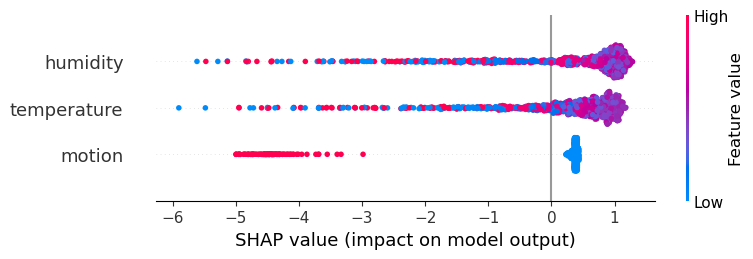

In [22]:
# 1. SHAP degerlerini hesaplamak icin TreeExplainer kullanalim
explainer = shap.Explainer(model, X_scaled)
shap_values = explainer(X_scaled)

# 2. Ozet grafik: Ozelliklerin modele etkisi
shap.summary_plot(shap_values, features=df_iot[features], feature_names=features)

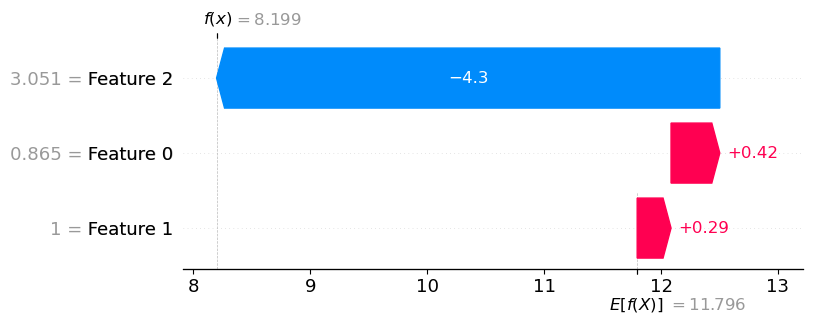

In [24]:
# Ornegin: anomaly_pred = 1 olan ilk satiri alalim
anomaly_index = df_iot[df_iot['anomaly_pred'] == 1].index[0]

# Bireysel aciklama (force plot)
shap.plots.waterfall(shap_values[anomaly_index])